In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('binned_df.csv')
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_df = df[df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["PatientID"].isin(train_ids)].reset_index(drop=True)
print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Train Data: (150144, 15)
Test Data: (37536, 15)


In [ ]:

state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

def calculate_reward(cur_SOFA, next_SOFA, cur_MAP, next_MAP):
    reward = 0
    c0 = -0.025
    c1 = -0.125
    c2 = 0.4
    map_reward = 0
    if cur_SOFA == next_SOFA and next_SOFA > 0:
        reward += c0
    if cur_MAP == 3 and next_MAP == 3: #MAP stays at normal level
        map_reward = 0
    elif cur_MAP == next_MAP: #MAP stays at low level
        map_reward = (-3 + cur_MAP) * 0.5
    elif cur_MAP > next_MAP: #MAP deteriorates
        map_reward = (next_MAP - cur_MAP) * (4 - cur_MAP) * 0.8
    elif cur_MAP < next_MAP: #MAP improves
        map_reward = next_MAP - cur_MAP
    return reward + c1 * (next_SOFA - cur_SOFA) + c2 * map_reward

def calculate_sofa_score(MAP, dbp, sbp, urine, ALT, AST, lactic_acid, serum_creatinine, p_f_ratio, GCS_total):
    cardiovascular_score = 0
    if MAP < 3:
        cardiovascular_score = 1

    respitory_score = 0
    if p_f_ratio == 0:
        respitory_score = 4
    elif p_f_ratio == 1:
        respitory_score = 3
    elif p_f_ratio == 2:
        respitory_score = 2
    else:
        respitory_score = 1

    renal_score = serum_creatinine

    if urine == 1:
        renal_score = max(renal_score, 3)
    if urine == 0:
        renal_score = max(renal_score, 4)

    liver_score = 0
    if (ALT > 0 and AST > 0):
        liver_score = 1
    if (ALT > 1 or AST > 1):
        liver_score = 2
    if (ALT > 2 or AST > 2):
        liver_score = 3

    neuro_score = 0
    if GCS_total == 0:
        neuro_score = 4
    elif GCS_total == 1:
        neuro_score = 3
    elif GCS_total  == 2:
        neuro_score = 2
    elif GCS_total == 3:
        neuro_score = 1

    lactic_acid_score = 0
    if lactic_acid > 0:
        lactic_acid_score = 2

    return cardiovascular_score + respitory_score + renal_score + liver_score + neuro_score + lactic_acid_score


In [ ]:
import torch
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

def create_transitions(df):
    df_size = len(df) / 48 * 47
    print(df_size)
    print(type(df_size))
    state_cols = [f"state_{i}" for i in range(len(state_columns + action_columns))]
    X = torch.zeros((int(df_size), len(state_columns) + len(action_columns)), device="cuda")
    y = torch.zeros((int(df_size), len(state_columns)), device="cuda")
    i = 0
    for patient in df['PatientID'].unique():
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for t in range(len(patient_records) - 1):
            current_state = torch.tensor(patient_records.iloc[t][state_columns + action_columns].values, device="cuda")
            next_state = torch.tensor(patient_records.iloc[t + 1][state_columns].values, device="cuda")
            X[i] = current_state
            y[i] = next_state
            i+=1
    return pd.DataFrame(X.cpu().numpy(), columns=state_columns + action_columns), pd.DataFrame(y.cpu().numpy(), columns=state_columns)

X, y = create_transitions(train_df)

knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in state_columns}
for col in state_columns:
    knn_models[col].fit(X, y[col])



147016.0
<class 'float'>


In [ ]:
train_df_sorted1 = train_df.sort_values(by=state_columns, ascending=True)
state_dict = {tuple(row): idx for idx, row in enumerate(train_df_sorted1[state_columns].drop_duplicates().values)}
train_df_sorted2 = train_df.sort_values(by=state_columns, ascending=True)
action_dict = {tuple(row): idx for idx, row in enumerate(train_df_sorted2[action_columns].drop_duplicates().values)}
inverse_state_dict = {v: k for k, v in state_dict.items()}
inverse_action_dict = {v: k for k, v in action_dict.items()}


In [ ]:
state_action_dict = {}
for _, row in X[state_columns + action_columns].drop_duplicates().iterrows():
    state_tuple = tuple(row[state_columns].values)
    state_idx = state_dict[state_tuple]
    if state_idx not in state_action_dict:
        state_action_dict[state_idx] = []
    action_tuple = tuple(row[action_columns].values)
    action_idx = action_dict[action_tuple]
    if action_idx not in state_action_dict[state_idx]:
        state_action_dict[state_idx].append(action_idx)

In [ ]:
def find_closest_index(input_tuple):
    closest_index = None
    min_distance = float('inf')

    for value, index in state_dict.items():
        distance = np.linalg.norm(np.array(value) - np.array(input_tuple))

        if distance < min_distance:
            min_distance = distance
            closest_index = index

    return closest_index

In [ ]:
q_table = torch.zeros((len(state_dict), len(action_dict)), device="cuda")
alpha = 0.1
gamma = 0.99

In [ ]:
diffs=[]

In [ ]:
def dyna_q_train(train_df, num_iterations, num_simulations):
    global q_table
    for iteration in range(num_iterations):
        q_backup = q_table.clone()
        for patient in train_df['PatientID'].unique():
            patient_records = train_df[train_df['PatientID'] == patient].reset_index(drop=True)
            for t in range(len(patient_records) - 1):
                current_row = torch.tensor(patient_records.iloc[t][state_columns].values, device="cuda")
                next_row = torch.tensor(patient_records.iloc[t + 1][state_columns].values, device="cuda")
                action = torch.tensor(patient_records.iloc[t][action_columns].values, device="cuda")

                current_state_index = state_dict[tuple(current_row.cpu().numpy())]
                action_index = action_dict[tuple(action.cpu().numpy())]

                reward = calculate_reward(
                    calculate_sofa_score(*current_row),
                    calculate_sofa_score(*next_row),
                    current_row[0],
                    next_row[0]
                )

                next_state_index = state_dict[tuple(next_row.cpu().numpy())]
                best_next_q = torch.max(q_table[next_state_index])

                q_table[current_state_index, action_index] += alpha * (
                    reward + gamma * best_next_q - q_table[current_state_index, action_index])

                for _ in range(num_simulations):
                    sim_state_index = random.choice(list(state_action_dict.keys()))
                    sim_action_index = random.choice(state_action_dict[sim_state_index])

                    sim_state = torch.tensor(inverse_state_dict[sim_state_index], device="cuda")
                    sim_action = torch.tensor(inverse_action_dict[sim_action_index], device="cuda")

                    sim_next_state = []
                    for col in state_columns:
                        sim_next_state.append(knn_models[col].predict(
                            pd.concat([pd.Series(sim_state.cpu().numpy(), index=state_columns),
                                       pd.Series(sim_action.cpu().numpy(), index=action_columns)], axis=0)
                            .to_frame().T).item())

                    sim_next_state = torch.tensor(sim_next_state, device="cuda")
                    sim_reward = calculate_reward(
                        calculate_sofa_score(*sim_state),
                        calculate_sofa_score(*sim_next_state),
                        sim_state[0],
                        sim_next_state[0]
                    )

                    sim_next_state_tuple = tuple(sim_next_state.cpu().numpy())
                    if sim_next_state_tuple in state_dict:
                        sim_next_state_index = state_dict[sim_next_state_tuple]
                    else:
                        sim_next_state_index = find_closest_index(sim_next_state_tuple)

                    best_sim_next_q = torch.max(q_table[sim_next_state_index])

                    q_table[sim_state_index, sim_action_index] += alpha * (
                        sim_reward + gamma * best_sim_next_q - q_table[sim_state_index, sim_action_index])

        diff = torch.mean(torch.abs(q_table - q_backup))
        diffs.append(diff.item())
        print(f"Q-table difference after iteration {iteration + 1}: {diff.item()}")



    return q_table

In [ ]:
import matplotlib.pyplot as plt
q_table = dyna_q_train(train_df, num_iterations=10, num_simulations=1)

In [ ]:
q_table_df = pd.DataFrame(q_table.cpu().numpy())
q_table_df.to_csv("q_table1.csv")

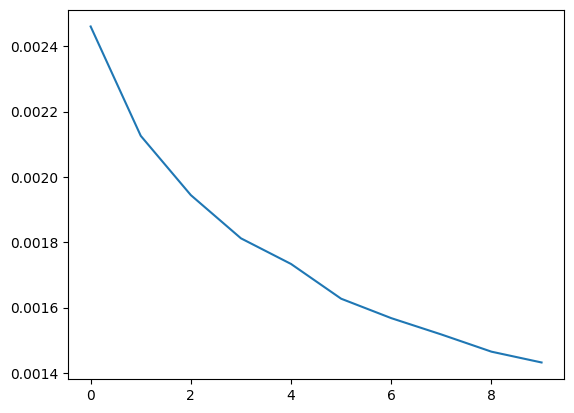

In [ ]:
plt.plot(diffs)
plt.show()

In [ ]:
print(diffs)

[0.0024604781065136194, 0.002125852508470416, 0.0019443982746452093, 0.0018121874891221523, 0.0017336916644126177, 0.0016273751389235258, 0.0015679321950301528, 0.0015179699985310435, 0.0014653161633759737, 0.0014322529314085841]


In [ ]:
diffs=[]

In [ ]:
q_table = dyna_q_train(train_df, num_iterations=10, num_simulations=3)

Iteration 1/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 1: 0.00535089336335659
Iteration 2/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 2: 0.004617869853973389
Iteration 3/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 3: 0.0040853326208889484
Iteration 4/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 4: 0.0036815544590353966
Iteration 5/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 5: 0.003362438175827265
Iteration 6/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 6: 0.0030800814274698496
Iteration 7/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 7: 0.0028842459432780743
Iteration 8/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 8: 0.002626964822411537
Iteration 9/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after iteration 9: 0.002423664787784219
Iteration 10/10
0
10
20
30
40
50
60
70
80
90
Q-table difference after 

In [ ]:
q_table_df = pd.DataFrame(q_table.cpu().numpy())
q_table_df.to_csv("q_table2.csv")